In [1]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import  LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import xgboost
import pickle

ImportError: cannot import name 'dtensor' from 'tensorflow.compat.v2.experimental' (C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\_api\v2\compat\v2\experimental\__init__.py)

**Stock price prediction in 15 minutes for Microsoft, combining models and indicators.**

# DATA COLLECTION

In [ ]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='D8JHWTNSXO7M9VKV', output_format='pandas')

In [ ]:
data = ts.get_intraday(symbol='MSFT',interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

,open,high,low,close,volume
date,,,,,
2023-06-26 19:45:00,329.70,330.00,329.50,329.74,3637.0
2023-06-26 19:30:00,329.76,330.00,329.50,329.70,4756.0
2023-06-26 19:15:00,329.53,330.00,328.60,329.84,23647.0
2023-06-26 19:00:00,329.08,329.74,328.87,329.52,6428.0
2023-06-26 18:45:00,329.00,329.29,328.81,328.82,954.0
...,...,...,...,...,...
2023-05-30 05:00:00,336.30,336.70,336.00,336.35,8878.0
2023-05-30 04:45:00,337.17,337.17,336.00,336.41,9615.0
2023-05-30 04:30:00,336.32,337.43,336.25,337.17,12467.0


# INDICATORS CALCULATION

In [ ]:
from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key='D8JHWTNSXO7M9VKV', output_format='pandas')

## 1. Rate of Change (ROC)

In [ ]:
indicator_roc = ti.get_roc(symbol='MSFT', interval='15min', time_period=20)
indicator_roc = indicator_roc[0]
indicator_roc

,ROC
date,
2023-05-30 09:00:00,0.3038
2023-05-30 09:15:00,-0.3893
2023-05-30 09:30:00,-0.4864
2023-05-30 09:45:00,-1.3555
2023-05-30 10:00:00,-1.5460
...,...
2023-06-26 18:45:00,-0.3485
2023-06-26 19:00:00,-0.1681
2023-06-26 19:15:00,-0.0364


## 2. Simple Moving Average (SMA)

In [ ]:
indicator_sma = ti.get_sma(symbol='MSFT', interval='15min', time_period=20)
indicator_sma = indicator_sma[0]
indicator_sma

,SMA
date,
2023-05-30 08:45:00,336.6495
2023-05-30 09:00:00,336.7005
2023-05-30 09:15:00,336.6350
2023-05-30 09:30:00,336.5530
2023-05-30 09:45:00,336.3250
...,...
2023-06-26 18:45:00,329.3116
2023-06-26 19:00:00,329.2839
2023-06-26 19:15:00,329.2779


## 3. Relative Strength Index (RSI)

In [ ]:
indicator_rsi = ti.get_rsi(symbol='MSFT', interval='15min', time_period=20)
indicator_rsi = indicator_rsi[0]
indicator_rsi

## 4. Bolling Bands (BBANDS)

In [ ]:
def BollingerBand(data, n_loockback, n_std=2):
    hlc_avg = (data.high + data.low + data.close)/3
    data_std = hlc_avg.rolling(window=n_loockback).std()
    data_upper = data.SMA + n_std * data_std
    data_lower = data.SMA - n_std * data_std
    return data.SMA, data_lower, data_upper

In [ ]:
# indicator_bb = ti.get_bbands(symbol='MSFT', interval='15min', time_period=20)
# indicator_bb = indicator_bb[0]
# indicator_bb

**Merge indicators to data**

In [ ]:
original_df = pd.merge(data, indicator_roc, on='date', how='inner')
original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
# original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
original_df["Real Middle Band"], original_df["Real Lower Band"], original_df["Real Upper Band"] = BollingerBand(original_df, 20, 2)
original_df = original_df.dropna()
original_df = original_df.iloc[::-1]
original_df.to_csv('./DATA/MSFT.csv')
original_df

,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band
date,,,,,,,,,,,
2023-05-30 09:00:00,336.65,336.800,336.45,336.720,36329.0,0.3038,336.7005,58.4437,336.7005,333.767873,339.633127
2023-05-30 09:15:00,336.63,337.000,334.80,335.210,99194.0,-0.3893,336.6350,46.2679,336.6350,334.292771,338.977229
2023-05-30 09:30:00,335.23,335.740,332.88,335.530,4039489.0,-0.4864,336.5530,48.6542,336.5530,334.773484,338.332516
2023-05-30 09:45:00,335.56,335.580,330.58,331.850,2107766.0,-1.3555,336.3250,31.6431,336.3250,334.961857,337.688143
2023-05-30 10:00:00,331.80,332.131,330.59,331.150,1311465.0,-1.5460,336.0650,29.5728,336.0650,334.710192,337.419808
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26 14:00:00,329.96,330.365,329.70,330.075,445942.0,-1.4731,332.0485,35.6387,332.0485,330.466112,333.630888
2023-06-26 14:15:00,330.06,330.080,329.52,329.960,366852.0,-1.2125,331.8460,35.1969,331.8460,330.279465,333.412535
2023-06-26 14:30:00,329.94,331.000,329.87,330.980,467913.0,-1.0996,331.6620,41.9190,331.6620,330.103414,333.220586


# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[336.72 ],
       [335.21 ],
       [335.53 ],
       ...,
       [330.98 ],
       [330.37 ],
       [329.915]])

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.50536553],
       [0.45472837],
       [0.46545942],
       ...,
       [0.31287726],
       [0.29242119],
       [0.27716298]])

In [ ]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1117
1117


In [ ]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (894, 60, 1)
Size validate:  (112, 60, 1)
Size test:  (111, 60, 1)


### b. Train Model

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

Epoch 1/20
28/28 [==============================] - 2s 33ms/step - loss: 0.0308 - val_loss: 0.0026
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 3/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 4/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 5/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 9.1714e-04
Epoch 10/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0016 - val_loss: 9.4047e-04
E

### c. Test Model

In [ ]:
model_lstm = load_model('./MODEL/LSTM.h5')

In [ ]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1066,2023-06-22 19:30:00,340.31,340.400,340.18,340.270,4121.0,0.4991,339.8570,65.8028,339.8570,338.036420,341.677580,340.025726
1067,2023-06-22 19:45:00,340.28,340.400,339.62,339.620,6694.0,0.2024,339.8913,58.1992,339.8913,338.335483,341.447117,340.039154
1068,2023-06-23 04:00:00,338.02,338.980,337.79,338.000,3293.0,-0.2597,339.8473,44.6605,339.8473,338.361414,341.333186,339.931641
1069,2023-06-23 04:15:00,338.00,338.040,337.38,337.440,1654.0,-0.3485,339.7883,41.1752,339.7883,338.074026,341.502574,339.520081
1070,2023-06-23 04:30:00,337.50,337.970,337.50,337.770,1242.0,-0.4412,339.7135,43.8913,339.7135,337.913969,341.513031,338.927734
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,2023-06-26 14:00:00,329.96,330.365,329.70,330.075,445942.0,-1.4731,332.0485,35.6387,332.0485,330.466112,333.630888,329.504303
1173,2023-06-26 14:15:00,330.06,330.080,329.52,329.960,366852.0,-1.2125,331.8460,35.1969,331.8460,330.279465,333.412535,329.511810
1174,2023-06-26 14:30:00,329.94,331.000,329.87,330.980,467913.0,-1.0996,331.6620,41.9190,331.6620,330.103414,333.220586,329.538544
1175,2023-06-26 14:45:00,330.97,331.000,330.29,330.370,363906.0,-1.5026,331.4100,39.3495,331.4100,329.937022,332.882978,329.708160


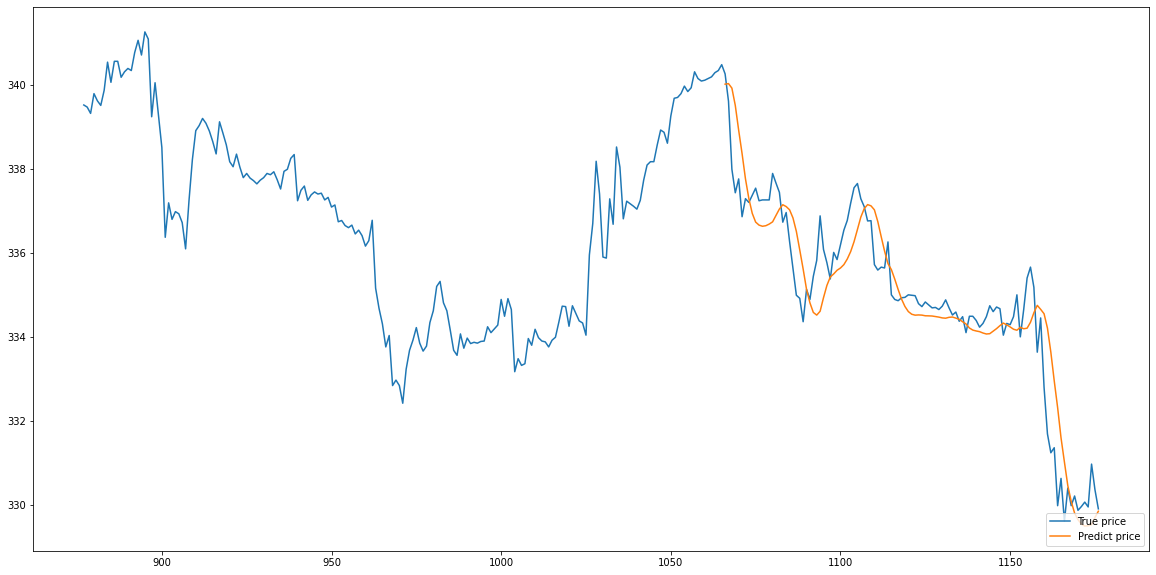

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 3.36720e+02,  3.03800e-01],
       [ 3.35210e+02, -3.89300e-01],
       [ 3.35530e+02, -4.86400e-01],
       ...,
       [ 3.30980e+02, -1.09960e+00],
       [ 3.30370e+02, -1.50260e+00],
       [ 3.29915e+02, -1.71450e+00]])

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.50536553, 0.52491186],
       [0.45472837, 0.41433608],
       [0.46545942, 0.39884495],
       ...,
       [0.31287726, 0.30101626],
       [0.29242119, 0.23672245],
       [0.27716298, 0.20291635]])

In [ ]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1117
1117


In [ ]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (894, 60, 2)
Size validate:  (112, 60, 2)
Size test:  (111, 60, 2)


In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
28/28 [==============================] - 2s 31ms/step - loss: 0.0390 - val_loss: 0.0049
Epoch 2/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 9.7426e-04
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 9.3452e-04
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 8.5327e-04
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 9.7049e-04
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 9.2853e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_lo

In [ ]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [ ]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]
predictions

array([339.82788, 339.79916, 339.62592, 339.15366, 338.57593, 338.06067,
       337.47736, 337.06   , 336.7664 , 336.6032 , 336.5735 , 336.5533 ,
       336.52594, 336.52234, 336.5358 , 336.66205, 336.769  , 336.81146,
       336.68915, 336.55588, 336.30582, 335.95935, 335.56107, 335.29208,
       335.0229 , 334.87012, 334.7903 , 334.78635, 334.8707 , 335.13538,
       335.27322, 335.3075 , 335.2161 , 335.19083, 335.15933, 335.14493,
       335.2276 , 335.396  , 335.6976 , 336.04077, 336.41306, 336.70294,
       336.9044 , 336.94876, 336.94104, 336.6353 , 336.25446, 335.86322,
       335.50537, 335.26352, 334.978  , 334.73895, 334.58228, 334.44836,
       334.37128, 334.31955, 334.27078, 334.2269 , 334.14423, 334.03845,
       333.96954, 333.95447, 333.9701 , 334.0224 , 334.06644, 334.18344,
       334.3223 , 334.39142, 334.37943, 334.29056, 334.23706, 334.2088 ,
       334.1151 , 334.05966, 334.0176 , 333.96124, 333.8792 , 333.81424,
       333.80603, 333.86838, 333.915  , 333.97363, 

In [ ]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1066,2023-06-22 19:30:00,340.31,340.400,340.18,340.270,4121.0,0.4991,339.8570,65.8028,339.8570,338.036420,341.677580,339.827881
1067,2023-06-22 19:45:00,340.28,340.400,339.62,339.620,6694.0,0.2024,339.8913,58.1992,339.8913,338.335483,341.447117,339.799164
1068,2023-06-23 04:00:00,338.02,338.980,337.79,338.000,3293.0,-0.2597,339.8473,44.6605,339.8473,338.361414,341.333186,339.625916
1069,2023-06-23 04:15:00,338.00,338.040,337.38,337.440,1654.0,-0.3485,339.7883,41.1752,339.7883,338.074026,341.502574,339.153656
1070,2023-06-23 04:30:00,337.50,337.970,337.50,337.770,1242.0,-0.4412,339.7135,43.8913,339.7135,337.913969,341.513031,338.575928
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,2023-06-26 14:00:00,329.96,330.365,329.70,330.075,445942.0,-1.4731,332.0485,35.6387,332.0485,330.466112,333.630888,329.450531
1173,2023-06-26 14:15:00,330.06,330.080,329.52,329.960,366852.0,-1.2125,331.8460,35.1969,331.8460,330.279465,333.412535,329.381744
1174,2023-06-26 14:30:00,329.94,331.000,329.87,330.980,467913.0,-1.0996,331.6620,41.9190,331.6620,330.103414,333.220586,329.379791
1175,2023-06-26 14:45:00,330.97,331.000,330.29,330.370,363906.0,-1.5026,331.4100,39.3495,331.4100,329.937022,332.882978,329.515533


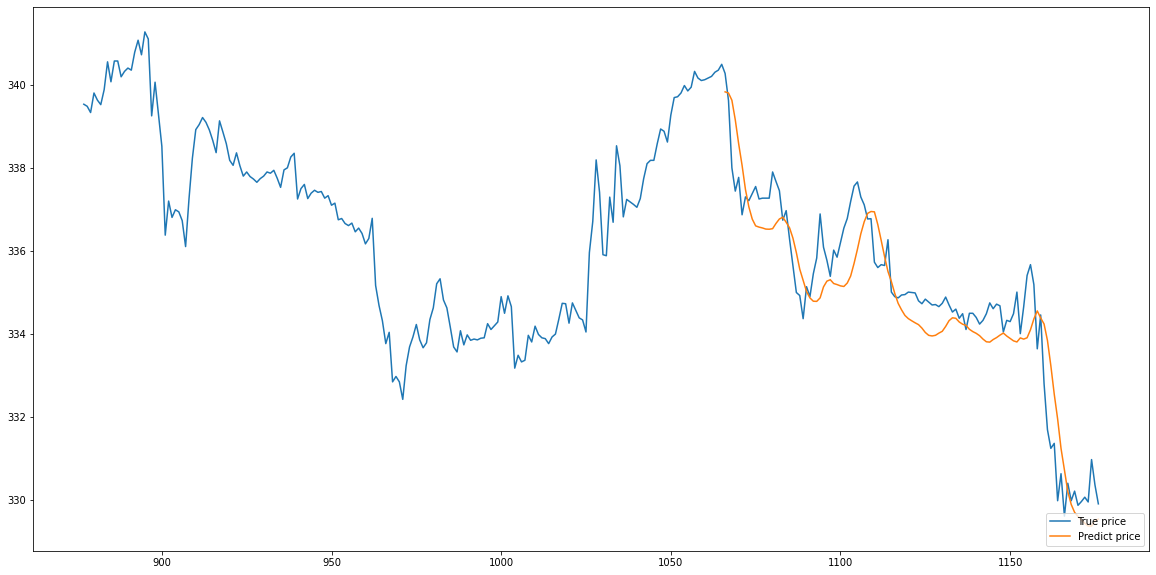

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/20
28/28 [==============================] - 2s 31ms/step - loss: 0.0255 - val_loss: 0.0037
Epoch 2/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 3/20
28/28 [==============================] - 1s 23ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 7/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 9.3417e-04
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0017 - val_loss: 9.6218e-04
E

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


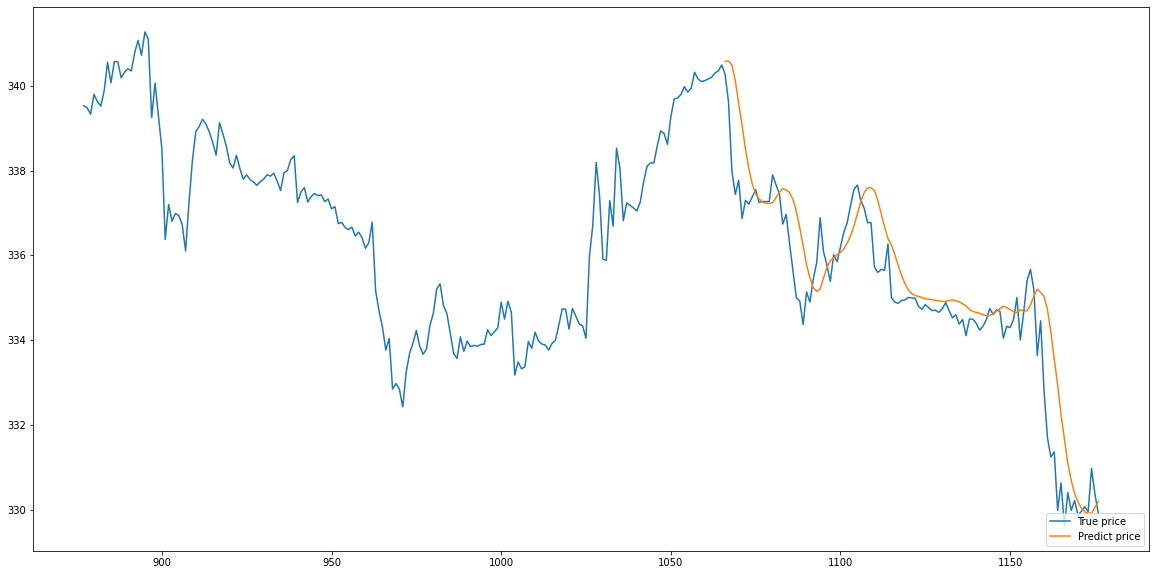

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/20
28/28 [==============================] - 3s 34ms/step - loss: 0.0286 - val_loss: 0.0032
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 9.5695e-04
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 8.2298e-04
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 7.4179e-04
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 7.2201e-04
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 9.1820e-04
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 7.8677e-04
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 6.7878e-04
Epoch 10/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0013 

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


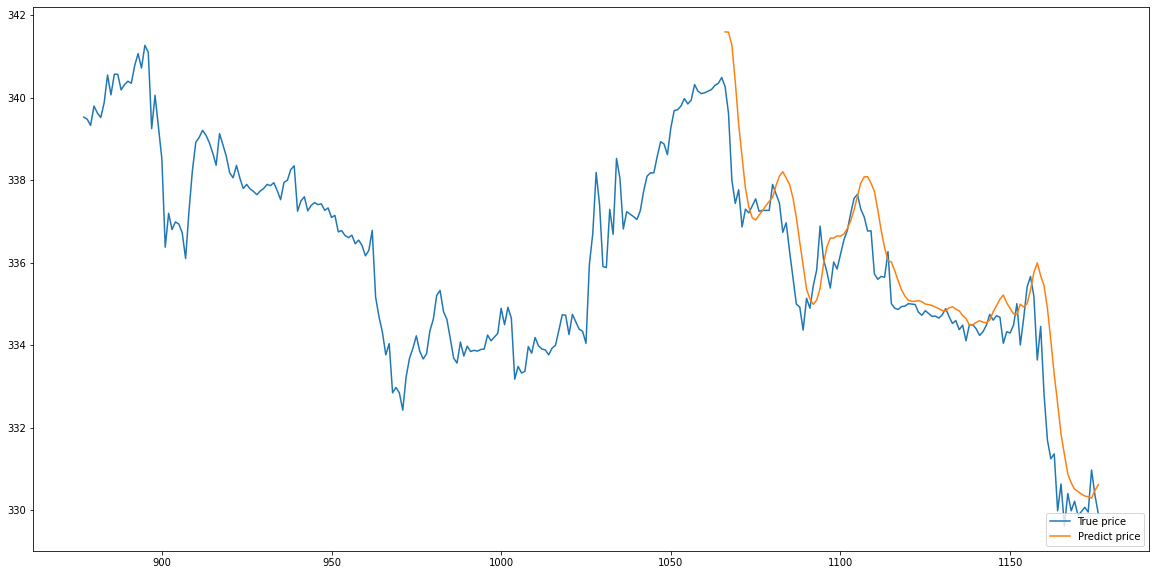

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/20
28/28 [==============================] - 2s 34ms/step - loss: 0.0154 - val_loss: 0.0025
Epoch 2/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 4/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 9.8917e-04
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 9.9970e-04
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 9.7395e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 0.00

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


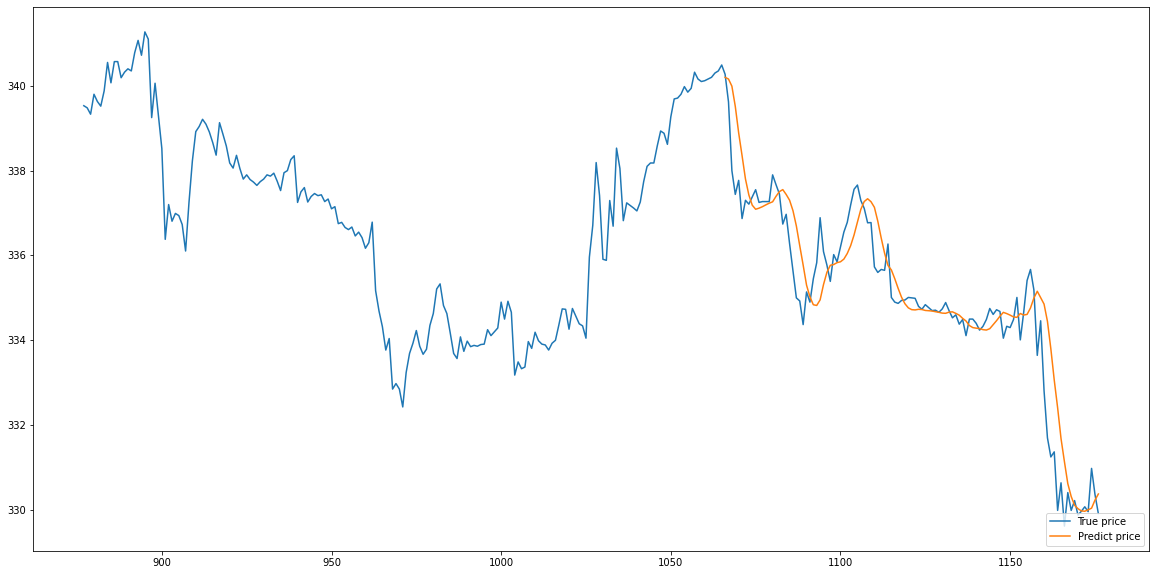

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/20
28/28 [==============================] - 2s 34ms/step - loss: 0.0244 - val_loss: 0.0028
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 3/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 9.6693e-04
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 9.3408e-04
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 9.5122e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 8.84

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


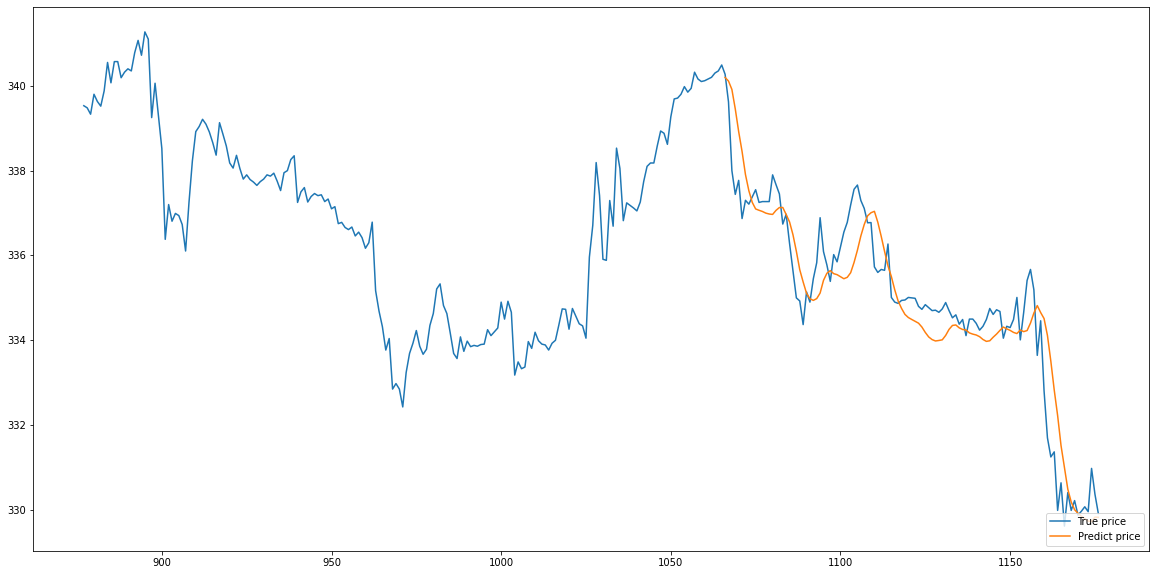

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/20
28/28 [==============================] - 2s 33ms/step - loss: 0.0151 - val_loss: 0.0022
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0026 - val_loss: 8.4838e-04
Epoch 3/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 6.9653e-04
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 7.3887e-04
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 7.9712e-04
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 7.7132e-04
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 6.8213e-04
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 9.7836e-04 - val_loss: 6.3051e-04
Epoch 10/20
28/28 [==============================] - 1s 20ms/step - loss: 9.4

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


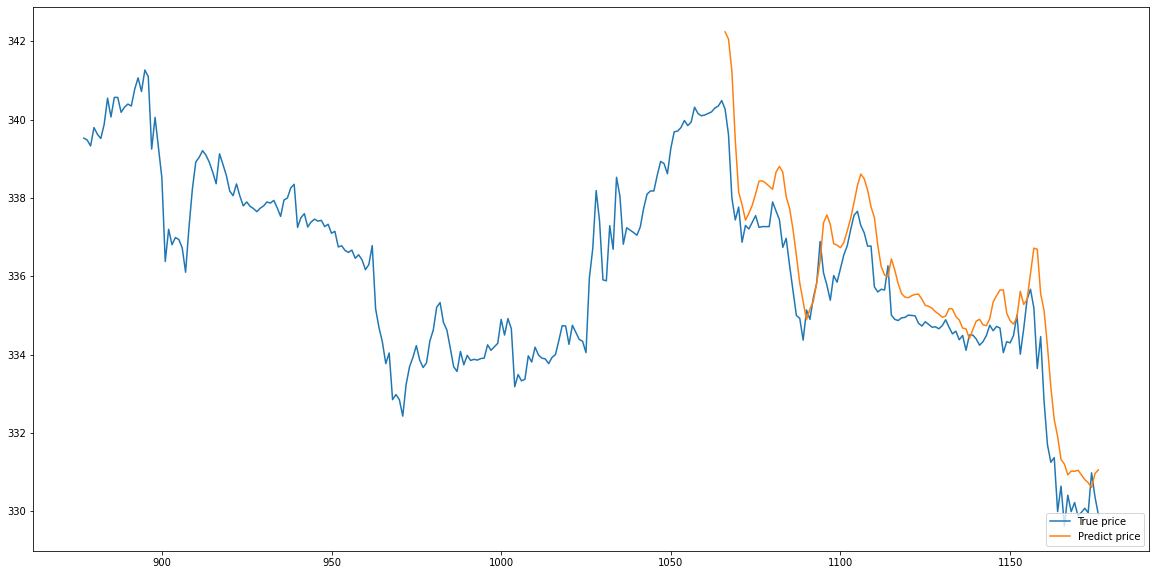

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/20
28/28 [==============================] - 3s 35ms/step - loss: 0.0175 - val_loss: 0.0022
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 4/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 5/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 7/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 9.4836e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 8.8869e-04
E

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


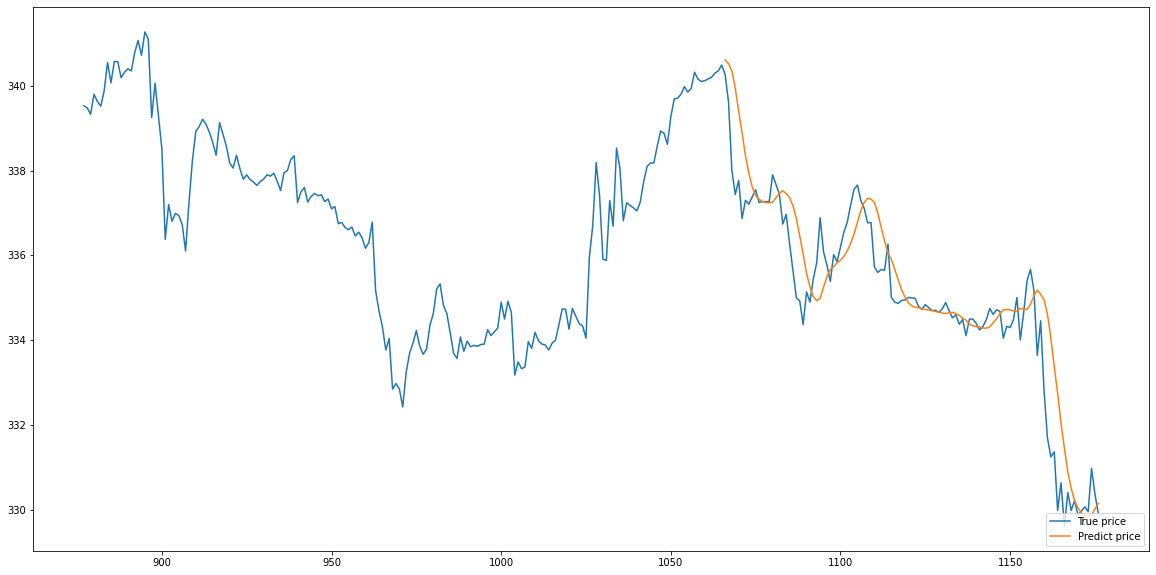

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/20
28/28 [==============================] - 2s 34ms/step - loss: 0.0363 - val_loss: 0.0035
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0036 - val_loss: 8.9734e-04
Epoch 3/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 8.0902e-04
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 7.5404e-04
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 7/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0016 - val_loss: 8.2555e-04
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 8.1648e-04
Epoch 9/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 7.5087e-04
Epoch 10/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0012 - va

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


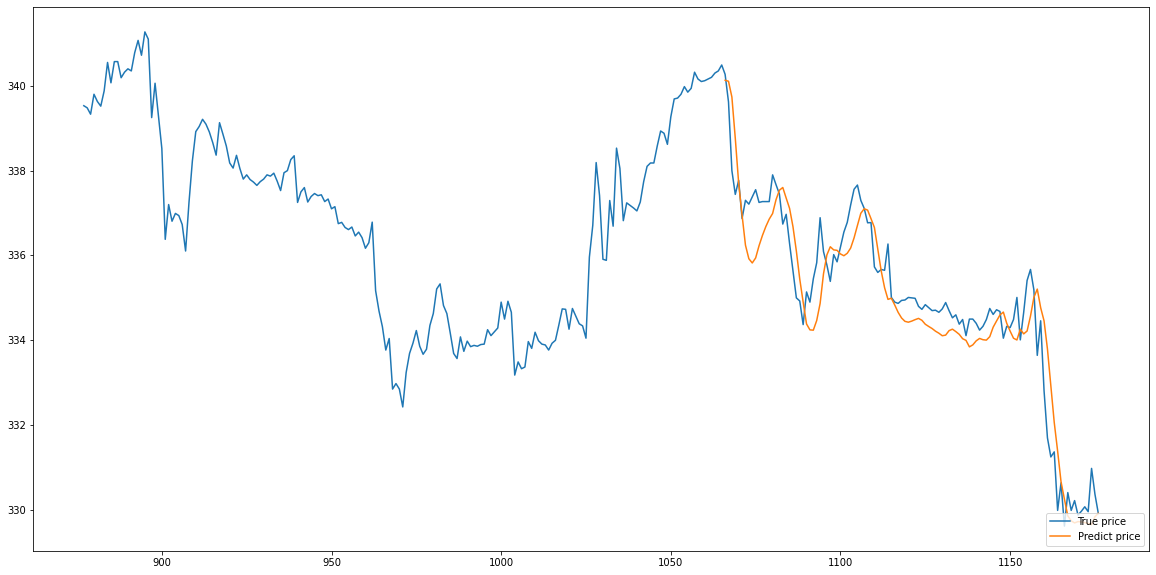

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/20
28/28 [==============================] - 3s 34ms/step - loss: 0.0209 - val_loss: 0.0018
Epoch 2/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0032 - val_loss: 8.3103e-04
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 8.0522e-04
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 6.9902e-04
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 9.8853e-04
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 9.5374e-04
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 8.0211e-04
Epoch 9/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 7.3192e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


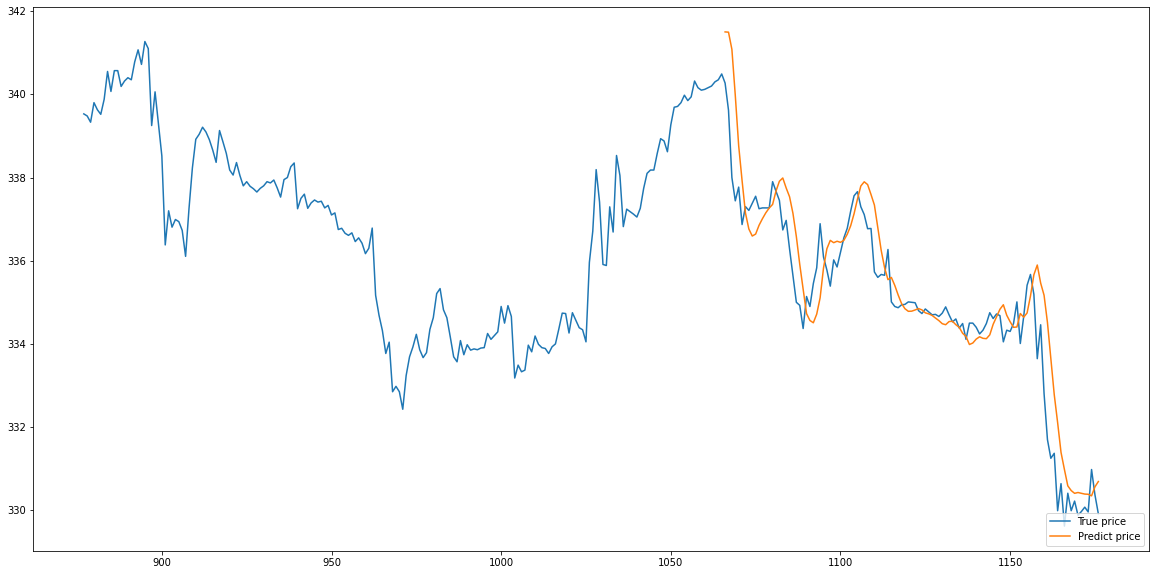

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/20
28/28 [==============================] - 2s 33ms/step - loss: 0.0310 - val_loss: 0.0026
Epoch 2/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0043 - val_loss: 0.0010
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 4/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 7.7440e-04
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 7.5190e-04
Epoch 9/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 10/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 7.2831e-

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


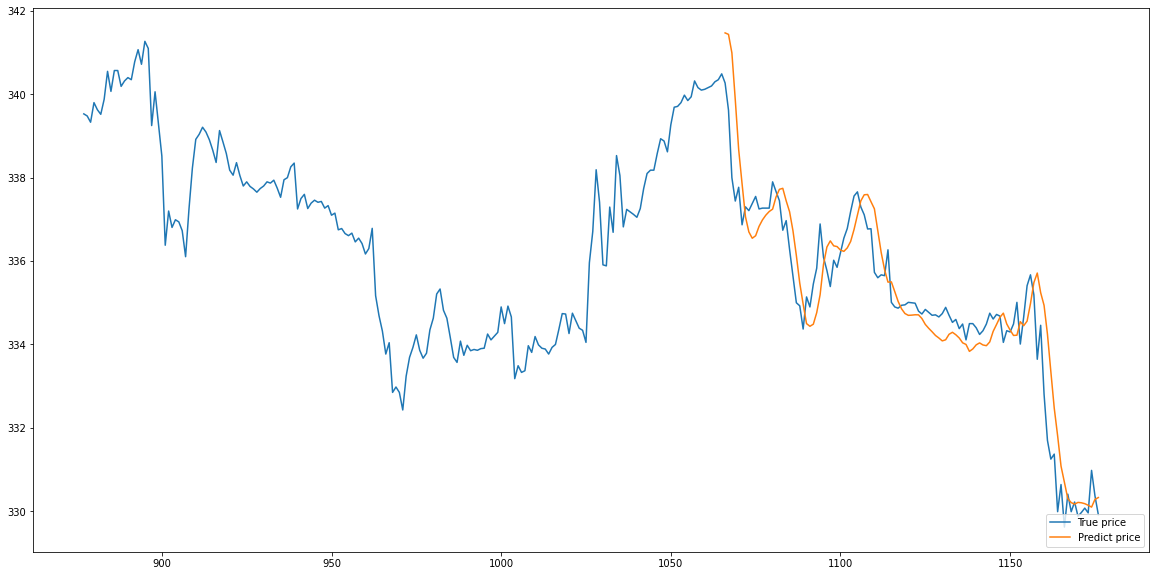

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/20
28/28 [==============================] - 3s 34ms/step - loss: 0.0403 - val_loss: 0.0119
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0072 - val_loss: 0.0029
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 7/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 9.8631e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 9.0224e-04
E

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


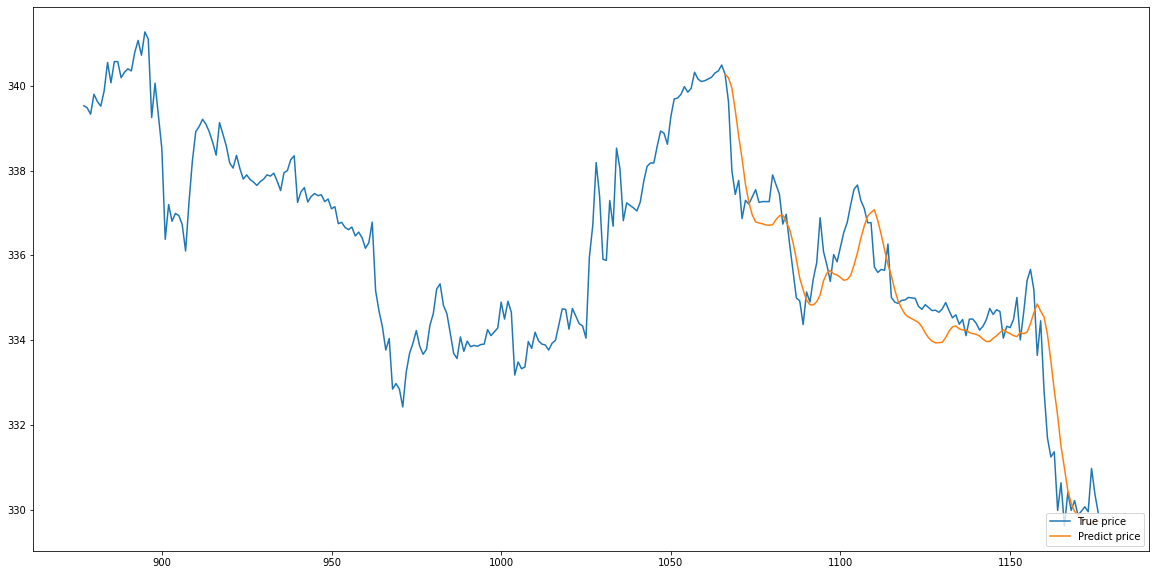

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/20
28/28 [==============================] - 2s 34ms/step - loss: 0.0368 - val_loss: 0.0044
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0028 - val_loss: 9.9816e-04
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 9.5109e-04
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 9.0928e-04
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 7.6223e-04
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 8.8054e-04
Epoch 9/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 7.3642e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - va

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


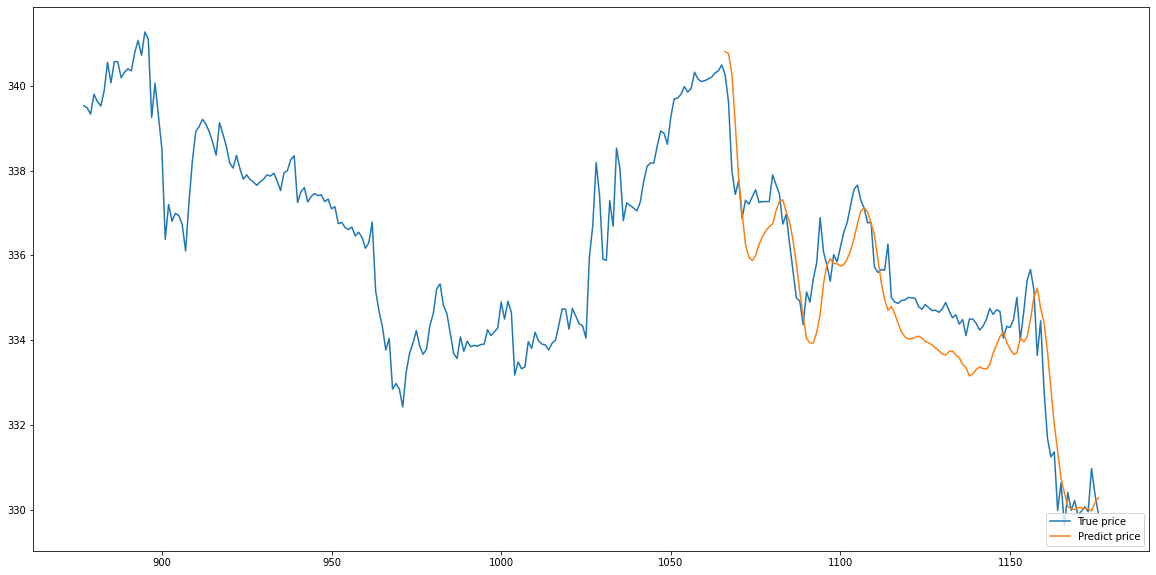

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/20
28/28 [==============================] - 3s 34ms/step - loss: 0.0220 - val_loss: 0.0037
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 7.9310e-04
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0016 - val_loss: 8.9595e-04
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 6.6212e-04
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 6.3712e-04
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 6.1694e-04
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 5.8979e-04
Epoch 9/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 6.7909e-04
Epoch 10/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0011 

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


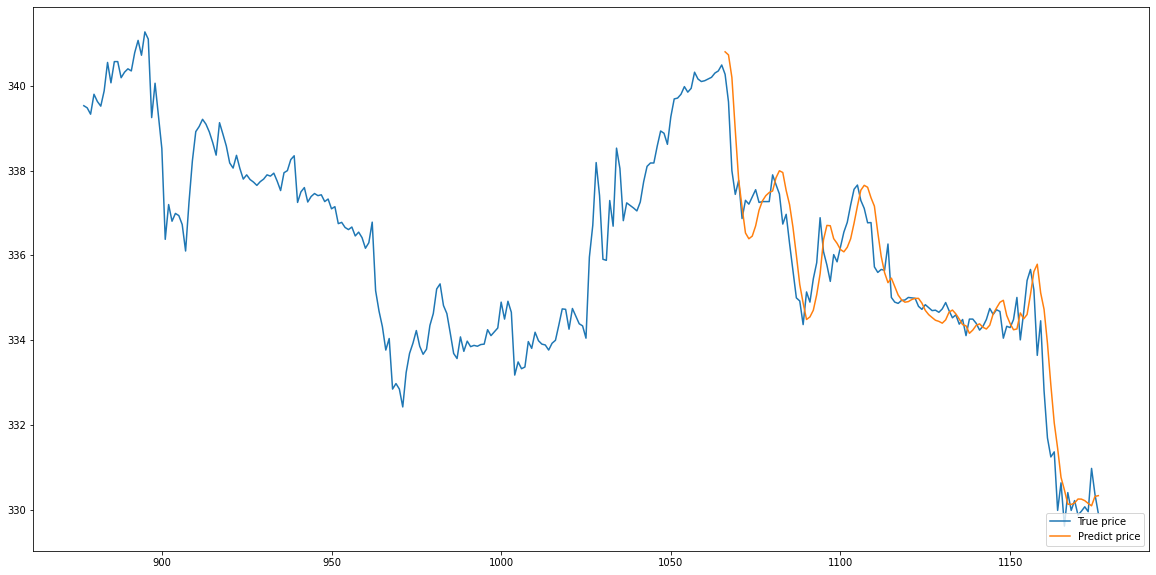

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/20
28/28 [==============================] - 2s 33ms/step - loss: 0.0307 - val_loss: 0.0097
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0024 - val_loss: 9.7075e-04
Epoch 4/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 7.8431e-04
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 8.1552e-04
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 6.4621e-04
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 6.2101e-04
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 6.0856e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0012 - va

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


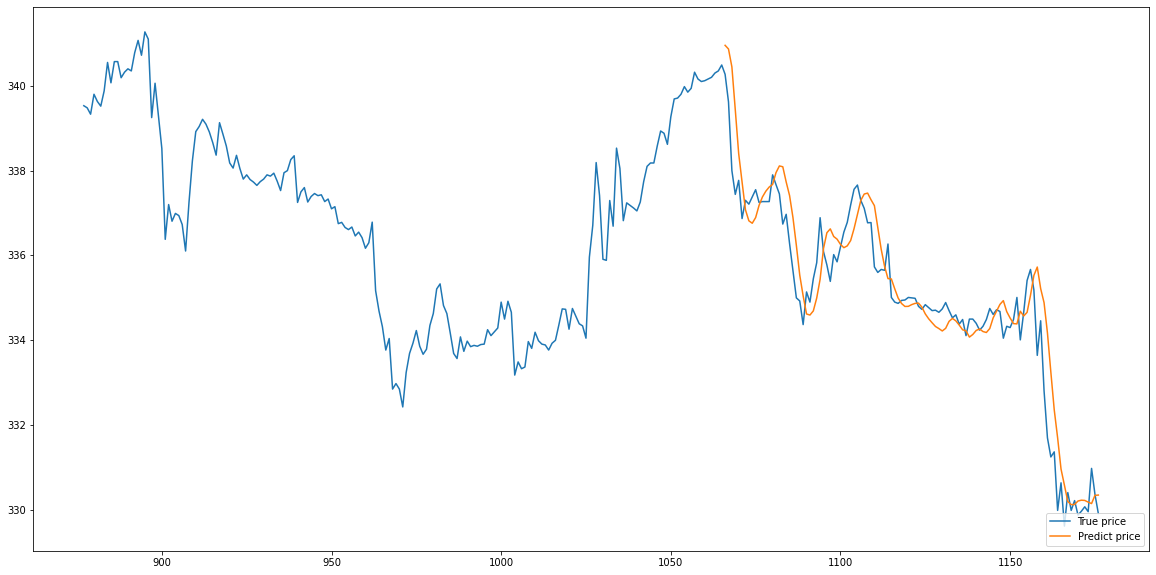

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### e. Predict Future

In [ ]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

## 2. RNN

### a. Prepare Input

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[336.72 ],
       [335.21 ],
       [335.53 ],
       ...,
       [330.98 ],
       [330.37 ],
       [329.915]])

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

In [ ]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1117
1117


In [ ]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (894, 60, 1)
Size validate:  (112, 60, 1)
Size test:  (111, 60, 1)


### b. Train Model

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN.h5")

Epoch 1/25
28/28 [==============================] - 5s 63ms/step - loss: 108992.4766 - val_loss: 108054.4922
Epoch 2/25
28/28 [==============================] - 1s 42ms/step - loss: 105426.6328 - val_loss: 105758.5234
Epoch 3/25
28/28 [==============================] - 1s 42ms/step - loss: 103829.0547 - val_loss: 104522.0391
Epoch 4/25
28/28 [==============================] - 1s 42ms/step - loss: 102681.9688 - val_loss: 103461.5469
Epoch 5/25
28/28 [==============================] - 1s 41ms/step - loss: 101652.8672 - val_loss: 102457.6406
Epoch 6/25
28/28 [==============================] - 1s 40ms/step - loss: 100682.2344 - val_loss: 101489.5625
Epoch 7/25
28/28 [==============================] - 1s 41ms/step - loss: 99720.0625 - val_loss: 100540.4453
Epoch 8/25
28/28 [==============================] - 1s 40ms/step - loss: 98800.4688 - val_loss: 99613.2109
Epoch 9/25
28/28 [==============================] - 1s 40ms/step - loss: 97884.5469 - val_loss: 98700.4609
Epoch 10/25
28/28 [=====

### c. Test Model

In [ ]:
model_rnn = load_model('./MODEL/RNN.h5')

In [ ]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions)

ValueError: non-broadcastable output operand with shape (111,1) doesn't match the broadcast shape (111,7)

In [ ]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

In [ ]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

In [ ]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC.h5")

In [ ]:
model_rnn = load_model('./MODEL/RNN_ROC.h5')

In [ ]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]

In [ ]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_SMA.h5")

model_rnn = load_model('./MODEL/RNN_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI.h5")

model_rnn = load_model('./MODEL/RNN_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

## 3. XGBOOST

### a. Prepare Input

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume']]
dataset

In [ ]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
dataset

In [ ]:
dataset.dropna(inplace=True)
dataset

In [ ]:
X = dataset.drop(['close', 'volume'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

In [ ]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

### b. Train Model

In [ ]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST.dat", "wb"))

### c. Test Model

In [ ]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST.dat", "rb"))

In [ ]:
predictions = model_xgboost.predict(X_test)
predictions

In [ ]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC']]
dataset

In [ ]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
dataset

In [ ]:
dataset.dropna(inplace=True)
dataset

In [ ]:
X = dataset.drop(['close', 'volume', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

In [ ]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

In [ ]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC.dat", "wb"))

In [ ]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC.dat", "rb"))

In [ ]:
predictions = model_xgboost.predict(X_test)
predictions

In [ ]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)


dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

In [ ]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Predict Future

In [ ]:
def xgboost_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.dat'
    model = pickle.load(open(modelFileName, "rb"))
    numDataPoint = int(period / 15)
    
    temp = indicatorArr.copy()
    temp.append('volume')
    data = data[temp]
    data = data[-5:]
    
    X = pd.DataFrame({})
    for column in data.columns:
        n = len(data)
        for i in range(1, n + 1):
            X[column + '_date_' + str(i)] = [data.iloc[n - i][column]] 
    
    predictedValue = model.predict(X)
    
    return predictedValue